In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
au_dataset = pd.read_csv(cfg_model.dataset_path).to_numpy()

In [5]:
au = au_dataset[:,:-1]
scaler = MinMaxScaler(feature_range=(0, 1))
au = scaler.fit_transform(au)
emotions = au_dataset[:,-1].astype(int)-1
au_dataset = [(x, y) for x, y in zip(au, emotions)]

In [6]:
trainingset_len = len(au_dataset) // 100 * 80
testset_len = len(au_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    au_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  7920 
test set size:  1982


In [7]:
use_cuda = True

model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'au_dim' : cfg_model.au_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'modes' : cfg_model.modes,
    'au_weight': cfg_model.au_weight,
    'emotion_weight': cfg_model.emotion_weight,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : cfg_train.use_cuda
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'betas' : cfg_train.static_annealing_beta,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'au_dim': 18, 'latent_space_dim': 25, 'hidden_dim': 128, 'num_filters': 32, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 10, 'emotion_weight': 0.001, 'expert_type': 'poe', 'use_cuda': True}
{'learning_rate': 0.0001, 'betas': 1e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 45, 'batch_size': 256}


In [8]:
load_model = True

if load_model:    
    PATH = "../trained_models/au-emo-poe-L2_49-84.save"
    loaded_data = torch.load(PATH)
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_state'])
      
    model.eval()
else:
    model: torch.nn.Module = build_model(**model_args).double()

In [9]:
train_model = False

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

In [10]:
if train_model: U.print_losses(training_losses)

In [11]:
save_model = False

if save_model:
    PATH = "../trained_models/au-emo-poe-L2_49-84.save"
    torch.save({'model_args' : model_args,
                'train_args': train_args,
                'model_state' : model.state_dict()
               }, PATH)

In [12]:
labels = list(Rd.emocat.values())

In [13]:
print('reg loss train: ' + str(U.au_to_au(model, dataset_loader).item()))
print('reg loss test: ' + str(U.au_to_au(model, testset_loader).item()))

reg loss train: 1.1054150720646522e-05
reg loss test: 1.2287263269661272e-05


100%|██████████████████████████████████████████| 31/31 [00:00<00:00, 133.48it/s]


              precision    recall  f1-score   support

     neutral       0.34      0.13      0.19       512
        calm       0.55      0.67      0.60      1078
       happy       0.69      0.75      0.72      1060
         sad       0.38      0.52      0.44      1071
       angry       0.55      0.11      0.18      1066
     fearful       0.48      0.40      0.44      1037
     disgust       0.59      0.72      0.65      1050
   surprised       0.34      0.46      0.39      1046

    accuracy                           0.49      7920
   macro avg       0.49      0.47      0.45      7920
weighted avg       0.50      0.49      0.47      7920



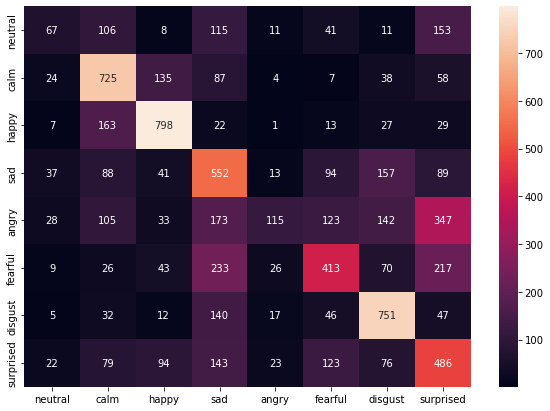

In [14]:
y_true, y_pred = U.au_classiffication_accuracy(model, dataset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 52.04it/s]


              precision    recall  f1-score   support

     neutral       0.32      0.16      0.21       133
        calm       0.54      0.65      0.59       255
       happy       0.71      0.76      0.74       264
         sad       0.38      0.54      0.45       258
       angry       0.42      0.09      0.15       272
     fearful       0.44      0.36      0.39       264
     disgust       0.64      0.77      0.70       293
   surprised       0.32      0.45      0.37       243

    accuracy                           0.49      1982
   macro avg       0.47      0.47      0.45      1982
weighted avg       0.49      0.49      0.47      1982



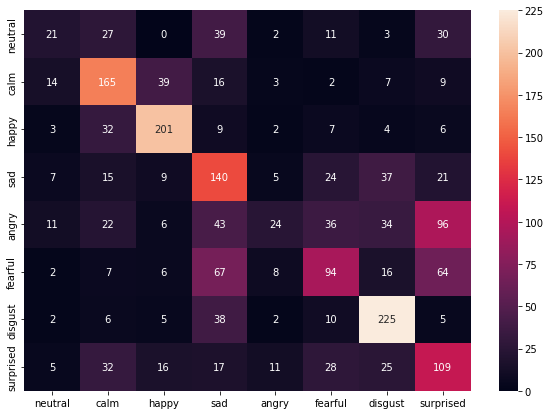

In [15]:
y_true, y_pred = U.au_classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|██████████████████████████████████████| 2048/2048 [00:04<00:00, 447.06it/s]


              precision    recall  f1-score   support

     neutral       0.95      0.71      0.81      4042
        calm       0.87      0.99      0.93      4142
       happy       0.93      0.99      0.96      4159
         sad       0.71      0.95      0.81      4060
       angry       0.93      0.45      0.60      3958
     fearful       0.79      0.68      0.73      4162
     disgust       0.86      0.95      0.90      4160
   surprised       0.73      0.92      0.81      4085

    accuracy                           0.83     32768
   macro avg       0.85      0.83      0.82     32768
weighted avg       0.85      0.83      0.82     32768



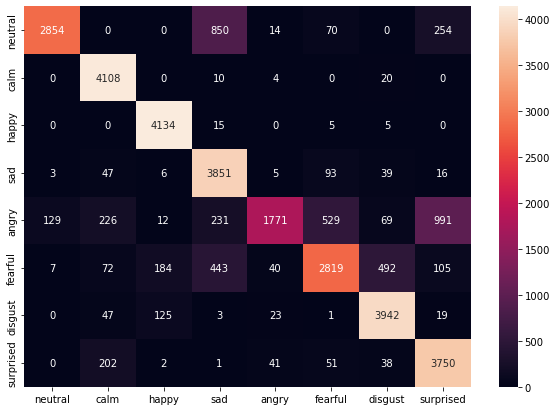

In [16]:
y_true, y_pred = U.au_recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

In [17]:
Rd.emocat

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

In [22]:
def generate_au(model, emo_idx):
    emo = torch.tensor([emo_idx]).cuda()

    r_au, _, _, _, _ = model(au=None, emotions=emo)
    r_au *= 10
    r_au.cpu()
    r_au = torch.clamp(r_au, min=0, max=5)
    r_au = r_au.round()
    
    print(Rd.emocat[emo_idx])
    print(r_au.tolist()[0])

In [40]:
generate_au(model, 4)

angry
[0.0, 0.0, 1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2.0, 1.0]
